# objective 
20230816 - revised 20231115 after Chengyu cleaned up data. 
sarahfong

learn the features of the US MPRA dataset

do some basic transformations and comparisons 

## transformations
- per replicate 
    
    - log2 normalize activity values
    - explore standard scaling log2 values (rep ctrl 2 has wider variance than other replicates) 

- across replicates
    - compute median, mean, sd of log2 values, standard scaling values 

## questions
- what is the variance between replicates? 
- How well do replicates correlate with one another?
    - pearson between replicates? 
    - spearman between replicates? 
- what is the correlation across replicate means, medians within group?

- is there are difference between log2 ratio and standard scaling activity? 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os, sys

import pandas as pd

import seaborn as sns
from scipy import stats
from sklearn.preprocessing import RobustScaler, StandardScaler

import sys

# Read, write to config

In [2]:
LOCAL = False
if LOCAL is True:
    sys.path.append("/Users/sarahfong/tools/py_")
    DATA_PATH = "/Users/sarahfong/Desktop/local_data/EMF/US"
else:
    DATA_PATH = "/wynton/group/ahituv/fongsl/projects/US/data"
import config_readwrite as crw
import plot_params as pp

pp.fonts()

('sans-serif', 'Arial', 18)

In [5]:
# read
config, cfn = crw.read(os.path.join(os.path.dirname(os.getcwd()), "config.ini"))

# path
#DATA_PATH = config["local_path"]["data"]

# make dictionary of values to write to config
config_dict = {
    "HEPG2": os.path.join(DATA_PATH, "full_hepg2_MPRA.csv"),
    "HEPG2.clean": os.path.join(DATA_PATH, "full_hepg2_MPRA.clean.csv"),
    "HEPG2.clean.transformed": os.path.join(DATA_PATH, "full_hepg2_MPRA.clean.transformed.csv"),
    "HEPG2.clean.trans.scaled": os.path.join(DATA_PATH, "full_hepg2_MPRA.clean.transformed.standard.scaled.csv"),
    "BJ": os.path.join(DATA_PATH, "full_bj_MPRA.csv"),
    "BJ.clean": os.path.join(DATA_PATH, "full_bj_MPRA.clean.csv"),
    "BJ.clean.transformed": os.path.join(DATA_PATH, "full_bj_MPRA.clean.transformed.csv"),
    "BJ.clean.trans.scaled": os.path.join(DATA_PATH, "full_bj_MPRA.clean.transformed.standard.scaled.csv"),
    "FASTA":os.path.join(DATA_PATH, "ultrasound_final_no_adapter.fasta")
}

# make data section of config
section = "data"
crw.check(config, section)

# add dictionary to config
for key, value in config_dict.items():
    config[section][key] = value
    
# write to config    
crw.write(config, cfn)

# functions

In [3]:
# mean, median, std

def computeStats(df, l2_ratios_list):
    """ compute median, mean, std of ctrl and ultrasound replicates per sequence"""
    print(l2_ratios_list[:3])
    df["l2.ratio.med.ctrl"] = df[l2_ratios_list[:3]].median(axis=1)
    df["l2.ratio.mean.ctrl"] = df[l2_ratios_list[:3]].mean(axis=1)
    df["l2.ratio.std.ctrl"] = df[l2_ratios_list[:3]].std(axis=1)

    df["l2.ratio.med.us"] = df[l2_ratios_list[3:]].median(axis=1)
    df["l2.ratio.mean.us"] = df[l2_ratios_list[3:]].mean(axis=1)
    df["l2.ratio.std.us"] = df[l2_ratios_list[3:]].std(axis=1)

    return df

# l2 transform (RNA/DNA)


def log2Transform(df, ratios_list):
    """ log2 transform each ratio column"""

    for ratio in ratios_list:
        df[f"l2.{ratio}"] = np.log2(df[ratio])

    return df

# get coordinates


def getCoordinates(df):
    """str split name to get genomic coordinates for endogenous sequences"""

    coordf = df.loc[df['name'].str.contains("chr")].copy()

    coordf["coor"] = coordf["name"].apply(
        lambda x: "chr"+x.split("chr")[1] if "chr" in x else None)

    # merge- add coordinates back to dataframe
    return pd.merge(df, coordf, how="left")

 # compute fold change of medians


def computeDelta(df):
    """ compute delta of log2 median us - log2 median control"""

    df["delta.med"] = df["l2.ratio.med.us"]-df["l2.ratio.med.ctrl"]
    df["delta.mean"] = df["l2.ratio.mean.us"]-df["l2.ratio.mean.ctrl"]

    return df


def clOrigin(df, constants_list):
    """annotate which cl a sequence was designed from"""

    df["cl.origin"] = None

    for cl in constants_list:
        df.loc[df['name'].str.contains(cl), "cl.origin"] = cl

    return df


def ctrlAnnot(df, constants_list):
    """ annotate control type (pos, neg, test)"""

    df["type"] = "None"
    for ctrl in constants_list:
        df.loc[df['label'].str.contains(ctrl), "type"] = ctrl

    return df


def computePval(df, constants_list):
    """ compute per sequence ttest of ctrl v. ultrasound rep
        assume equal_var is False 
    """
    df["pval"] = None
    for i, row in df.iterrows():

        # get control replicates
        ctrls = row[constants_list[:3]]

        # get US replicates
        uss = row[constants_list[3:]]
        # t-test per sequence, no equal variance assumed.
        t, p = stats.ttest_ind(list(ctrls), list(uss), equal_var=False)

        # update dataframe
        df.at[i, 'pval'] = p

    return df


def callActive(df):
    """call active elements from ctrl, us MPRA as values > 95 of shuffled regions"""

    # get shuffles
    shufs = df.loc[df.name.str.contains("shuf")].copy()

    # get 97.5% of shuffle median score for ctrl, US treatment
    ctrl_975 = shufs['l2.ratio.med.ctrl'].quantile(0.975)
    us_975 = shufs['l2.ratio.med.us'].quantile(0.975)

    ctrl_025 = shufs['l2.ratio.med.ctrl'].quantile(0.025)
    us_025 = shufs['l2.ratio.med.us'].quantile(0.025)
    print(ctrl_975, ctrl_025, us_975, us_025)

    # create column to label active
    df['label.ctrl'], df['label.us'] = 0, 0

    # label active elements - has more activity than 97.5% shuffles
    df.loc[df['l2.ratio.med.ctrl'] > ctrl_975, 'label.ctrl'] = 1
    df.loc[df['l2.ratio.med.us'] > us_975, 'label.us'] = 1

    # label active elements - has less activity than 2.5% shuffles
    df.loc[df['l2.ratio.med.ctrl'] < ctrl_025, 'label.ctrl'] = -1
    df.loc[df['l2.ratio.med.us'] < us_025, 'label.us'] = -1

    return df


def callResponse(df):
    df["response"] = False

    df.loc[(df["pval"] < 0.05) &
           (df['label.ctrl'] != df['label.us']),
           "response"
           ] = True

    # describe direction of values
    df["direction"] = None

    # direction when US is positive and ctrl is negative
    df.loc[(df["l2.ratio.med.ctrl"] < 0)
           & (df["l2.ratio.med.us"] >= 0), "direction"] = "US_UP"

    # when US is negative and ctrl is positive
    df.loc[(df["l2.ratio.med.ctrl"] > 0)
           & (df["l2.ratio.med.us"] <= 0), "direction"] = "US_DOWN"

    # Less silent when US is negative and ctrl is negative and US > CTRL
    df.loc[(df["l2.ratio.med.ctrl"] < 0)
           & (df["l2.ratio.med.us"] <= 0)
           & (df["l2.ratio.med.us"] > df["l2.ratio.med.ctrl"]), "direction"] = "LESS_SILENT"

    # More silent when US is negative and ctrl is negative and US < CTRL
    df.loc[(df["l2.ratio.med.ctrl"] < 0)
           & (df["l2.ratio.med.us"] <= 0)
           & (df["l2.ratio.med.us"] < df["l2.ratio.med.ctrl"]), "direction"] = "MORE_SILENT"

    # Less active when US is positive and ctrl is positive and CTRL > US
    df.loc[(df["l2.ratio.med.ctrl"] > 0)
           & (df["l2.ratio.med.us"] >= 0)
           & (df["l2.ratio.med.us"] < df["l2.ratio.med.ctrl"]), "direction"] = "LESS_ACTIVE"
    # more active when US is positive and ctrl is positive and CTRL < US
    df.loc[(df["l2.ratio.med.ctrl"] > 0)
           & (df["l2.ratio.med.us"] >= 0)
           & (df["l2.ratio.med.us"] > df["l2.ratio.med.ctrl"]), "direction"] = "MORE_ACTIVE"

    return df

# test CL 

## notes about this dataset
- Activity score - median score was assigned per US|CTRL for each sequence
- Active | inactive = test sequence score > 95% shuffled score. Both these scores are median score (above)
- logFC
- P-value

### input data

In [6]:
CL= "BJ" #"HEPG2" #
DATA = config_dict[CL]
CLEAN = config_dict[f"{CL}.clean.transformed"]
SCALED =config_dict[f'{CL}.clean.trans.scaled']

### constants dict

In [7]:
constants = {
    "NAMES" :['name',
         'label',
         'ratio.med.ctrl',
         'label.ctrl',
         'ratio.1.ctrl',
         'ratio.2.ctrl',
         'ratio.3.ctrl',
         'ratio.med.us',
         'label.us',
         'ratio.1.us',
         'ratio.2.us',
         'ratio.3.us',
         'pval',
              "p_adj", 
         'logFC',
         'response'],
    
    "CTRL_LIST" : ["NegCt", "PosCt", "Shuffle", "Synthetic", 'H3K27AC', "ATAC", "DEG", "non-diff"],
    
    "RATIOS": ['ratio.1.ctrl','ratio.2.ctrl', 'ratio.3.ctrl', 
          'ratio.1.us', 'ratio.2.us','ratio.3.us'],
    
    "L2RATIOS": ['l2.ratio.1.ctrl','l2.ratio.2.ctrl', 'l2.ratio.3.ctrl', 
          'l2.ratio.1.us', 'l2.ratio.2.us','l2.ratio.3.us'],
    "L2STD": ['l2.ratio.std.ctrl', 'l2.ratio.std.us'],
    
    "CL_LIST" :["k562", "hob", "bj", "hepg2"]
}

### load data

## without plus 1

In [8]:
df_ = pd.read_csv(DATA, skiprows=1, names=constants["NAMES"], low_memory=False)
df_.head()

,name,label,ratio.med.ctrl,label.ctrl,ratio.1.ctrl,ratio.2.ctrl,ratio.3.ctrl,ratio.med.us,label.us,ratio.1.us,ratio.2.us,ratio.3.us,pval,p_adj,logFC,response
0,SYNTHETIC:_Added_GGGGCGGGG_CAGAGCTG_CTGATAAGGA...,Synthetic,0.730707,inactive,0.732625,0.742659,0.716835,0.451288,inactive,0.453103,0.429931,0.470829,0.000125,0.999331,-0.695245,unresponsive
1,SYNTHETIC:_Added_TATACATA_GCCCGGGGG_TATACATA_A...,Synthetic,0.996278,inactive,0.986795,1.001141,1.000897,0.875493,inactive,0.863311,0.883304,0.879863,0.000153,0.999331,-0.186453,unresponsive
2,SYNTHETIC:_The_motif_CAGAGCTG_was_added_in_Pos...,Synthetic,0.759033,inactive,0.758425,0.768487,0.750188,0.655631,inactive,0.667361,0.650806,0.648725,0.000213,0.999331,-0.211280,unresponsive
3,SYNTHETIC:_The_motif_GAGATAAGGA_was_added_in_P...,Synthetic,0.921166,inactive,0.898376,0.940726,0.924395,0.708869,inactive,0.707967,0.690220,0.728420,0.000229,0.999331,-0.377942,unresponsive
4,k562_atac_up_chr1:67191823-67192092,Differential_ATAC,1.195409,inactive,1.196577,1.187511,1.202138,1.281130,active,1.282186,1.271701,1.289503,0.000265,0.999331,0.099912,ultrasound-responsive


In [11]:
if os.path.exists(CLEAN) is False:
    # load .csv data, rename columns, skip row 1 (old column names)
    df_ = pd.read_csv(DATA, skiprows=1, names=constants["NAMES"], low_memory=False)

    # annotate cell line origin
    df = clOrigin(df_, constants["CL_LIST"])

    # annotate controls
    df = ctrlAnnot(df,constants["CTRL_LIST"])

    # coordinates
    df = getCoordinates(df)

    # log2 transform ratios - increase sensitivity for ratios <1
    df = log2Transform(df, constants["RATIOS"])

    # compute stats
    df = computeStats(df, constants["L2RATIOS"])

    # compute difference between scaled
    df = computeDelta(df)

    # recall active
    df = callActive(df)

    # re compute pvalues 
    df = computePval(df, constants["L2RATIOS"])

    # recall response
    df = callResponse(df)
    # write the file
    
    df["pval"] = df["pval"].astype(float)
    df["-log10p"] = np.log10(df["pval"])*-1

    df.to_csv(CLEAN, sep='\t', index=False)
    print('wrote clean')
else:
    df = pd.read_csv(CLEAN, sep='\t')

In [12]:
df.head()

,Unnamed: 0,seq.id,name,name_mpra,label,ratio.med.ctrl,label.ctrl,ratio.1.ctrl,ratio.2.ctrl,ratio.3.ctrl,...,l2.ratio.med.ctrl,l2.ratio.mean.ctrl,l2.ratio.std.ctrl,l2.ratio.med.us,l2.ratio.mean.us,l2.ratio.std.us,delta.med,delta.mean,direction,-log10p
0,0,seq.20578,"SYNTHETIC:_Added_GGGGCGGGG,CAGAGCTG,CTGATAAGGA...",SYNTHETIC:_Added_GGGGCGGGG_CAGAGCTG_CTGATAAGGA...,Synthetic,0.730707,0,0.732625,0.742659,0.716835,...,-0.448852,-0.452789,0.025756,-1.142089,-1.148879,0.065812,-0.693236,-0.696090,MORE_SILENT,3.012779
1,1,seq.23154,"SYNTHETIC:_Added_TATACATA,GCCCGGGGG,TATACATA,A...",SYNTHETIC:_Added_TATACATA_GCCCGGGGG_TATACATA_A...,Synthetic,0.996278,0,0.986795,1.001141,1.000897,...,0.001294,-0.005413,0.011922,-0.184650,-0.191905,0.017670,-0.185943,-0.186492,US_DOWN,3.596080
2,2,seq.30854,SYNTHETIC:_The_motif_CAGAGCTG_was_added_in_Pos...,SYNTHETIC:_The_motif_CAGAGCTG_was_added_in_Pos...,Synthetic,0.759033,0,0.758425,0.768487,0.750188,...,-0.398922,-0.397835,0.017409,-0.619700,-0.609161,0.022377,-0.220778,-0.211326,MORE_SILENT,3.532975
3,3,seq.34101,SYNTHETIC:_The_motif_GAGATAAGGA_was_added_in_P...,SYNTHETIC:_The_motif_GAGATAAGGA_was_added_in_P...,Synthetic,0.921166,0,0.898376,0.940726,0.924395,...,-0.113418,-0.118727,0.033544,-0.498247,-0.496759,0.038879,-0.384828,-0.378032,MORE_SILENT,3.607266
4,4,seq.81227,k562_atac_up_chr1:67191823-67192092,k562_atac_up_chr1:67191823-67192092,Differential_ATAC,1.195409,0,1.196577,1.187511,1.202138,...,0.258913,0.257486,0.008917,0.358605,0.357393,0.010083,0.099692,0.099907,MORE_ACTIVE,3.637373


## QC old df v. new df

In [13]:
def harmonizeOldDf(df_):
    df_.loc[df_["label.ctrl"] == "inactive", "label.ctrl"] = False
    df_.loc[df_["label.ctrl"] == "active", "label.ctrl"] = True
    df_.loc[df_["label.us"] == "inactive", "label.us"] = False
    df_.loc[df_["label.us"] == "active", "label.us"] = True
    
    df_.loc[df_["response"] =="ultrasound-responsive", "response" ] = True
    df_.loc[df_["response"] =="unresponsive", "response" ] = False
    
    return df_

In [14]:
def checkCoor(old_df, new_df, col):
    """
    check correlations before and after log transforming data
    """
    old_col = 'old-'+col
    
    old = old_df[["name", col]].drop_duplicates()
    new = new_df[["name", col]].drop_duplicates()
    
    old = old.rename(columns={col:old_col})

    #print(list(old), list(new))
    
    m = pd.merge(old[["name", old_col]], 
                 new 
                )
    print(m[[old_col, col]].corr())
    
    return m

### harmonize old df with bool
- is the p value I compute different from the p-value chengyu computes? 

In [15]:
# load .csv data, rename columns, skip row 1 (old column names)
df_ = pd.read_csv(DATA, skiprows=1, names=constants["NAMES"], low_memory=False)

df_ = harmonizeOldDf(df_)

In [16]:
checkCoor(df_, df, "pval")  # calling activity in control

          old-pval      pval
old-pval  1.000000  0.997582
pval      0.997582  1.000000


,name,old-pval,pval
0,SYNTHETIC:_The_motif_CAGAGCTG_was_added_in_Pos...,0.000213,0.000293
1,SYNTHETIC:_The_motif_GAGATAAGGA_was_added_in_P...,0.000229,0.000247
2,k562_atac_up_chr1:67191823-67192092,0.000265,0.000230
3,k562_atac_down_chr1:3291059-3291328,0.000284,0.000284
4,hob_k27ac_up_chr2:196113625-196113894,0.000382,0.000533
...,...,...,...
37245,SYNTHETIC:_The_motif_TCCTTATCTC_was_added_in_P...,0.999841,0.976752
37246,bj_k27ac_up_chr2:121502953-121503222,0.999909,0.989544
37247,bj_atac_up_chr16:24913178-24913447,0.999922,0.967447
37248,hob_k27ac_up_chr20:41072388-41072657,0.999942,0.964716


### check label correlation - ctrl

In [17]:
checkCoor(df_, df, "label.ctrl")  # calling activity in control

                old-label.ctrl  label.ctrl
old-label.ctrl        1.000000    0.851129
label.ctrl            0.851129    1.000000


,name,old-label.ctrl,label.ctrl
0,SYNTHETIC:_The_motif_CAGAGCTG_was_added_in_Pos...,False,0
1,SYNTHETIC:_The_motif_GAGATAAGGA_was_added_in_P...,False,0
2,k562_atac_up_chr1:67191823-67192092,False,0
3,k562_atac_down_chr1:3291059-3291328,False,0
4,hob_k27ac_up_chr2:196113625-196113894,False,0
...,...,...,...
37245,SYNTHETIC:_The_motif_TCCTTATCTC_was_added_in_P...,False,0
37246,bj_k27ac_up_chr2:121502953-121503222,False,0
37247,bj_atac_up_chr16:24913178-24913447,False,0
37248,hob_k27ac_up_chr20:41072388-41072657,False,0


### check label correlation - us

In [18]:
checkCoor(df_, df, "label.us")  # calling activity in US

              old-label.us  label.us
old-label.us      1.000000  0.845463
label.us          0.845463  1.000000


,name,old-label.us,label.us
0,SYNTHETIC:_The_motif_CAGAGCTG_was_added_in_Pos...,False,0
1,SYNTHETIC:_The_motif_GAGATAAGGA_was_added_in_P...,False,0
2,k562_atac_up_chr1:67191823-67192092,True,1
3,k562_atac_down_chr1:3291059-3291328,False,0
4,hob_k27ac_up_chr2:196113625-196113894,False,0
...,...,...,...
37245,SYNTHETIC:_The_motif_TCCTTATCTC_was_added_in_P...,False,0
37246,bj_k27ac_up_chr2:121502953-121503222,False,0
37247,bj_atac_up_chr16:24913178-24913447,False,0
37248,hob_k27ac_up_chr20:41072388-41072657,False,0


In [19]:
checkCoor(df_, df, "response")

              old-response  response
old-response      1.000000  0.278154
response          0.278154  1.000000


,name,old-response,response
0,SYNTHETIC:_The_motif_CAGAGCTG_was_added_in_Pos...,False,False
1,SYNTHETIC:_The_motif_GAGATAAGGA_was_added_in_P...,False,False
2,k562_atac_up_chr1:67191823-67192092,True,True
3,k562_atac_down_chr1:3291059-3291328,False,False
4,hob_k27ac_up_chr2:196113625-196113894,False,False
...,...,...,...
37245,SYNTHETIC:_The_motif_TCCTTATCTC_was_added_in_P...,False,False
37246,bj_k27ac_up_chr2:121502953-121503222,False,False
37247,bj_atac_up_chr16:24913178-24913447,False,False
37248,hob_k27ac_up_chr20:41072388-41072657,False,False


In [22]:
df_.groupby("response")["name"].count(), df.groupby("response")["name"].count()  # more responses called in my strategt

(response
 False    58292
 True        41
 Name: name, dtype: int64,
 response
 False    57890
 True       290
 Name: name, dtype: int64)

not sure if response column rules are correct. Correct according to methods. 

In [23]:
df.groupby("direction")["name"].count()

direction
LESS_ACTIVE    10208
LESS_SILENT    13303
MORE_ACTIVE    13325
MORE_SILENT    17813
US_DOWN         1826
US_UP           1705
Name: name, dtype: int64

## Within group replicate correlation? 

### plot function

In [24]:
def plotCorrHeatMap(data,cols):
    """ plot pearson and spearman correlation between columns in a dataframe"""
    pearson = data[cols].corr()
    spearman = data[cols].corr(method="spearman")
    
    matrix_p = np.triu(pearson)
    matrix_s = np.triu(spearman)
    
    # pearson
    fig,ax=plt.subplots()
    sns.heatmap(pearson, 
                annot=True, 
                mask=matrix_p,
                center=0,
                cbar_kws={"label":"pearson"}) 

    # spearman
    fig,ax=plt.subplots()
    sns.heatmap(spearman, 
                annot=True,
                mask=matrix_s,
                center=0,
                cbar_kws={"label":"spearman"})

### within replicates, Pearson, Spearman

In [25]:
ratios=constants["L2RATIOS"]

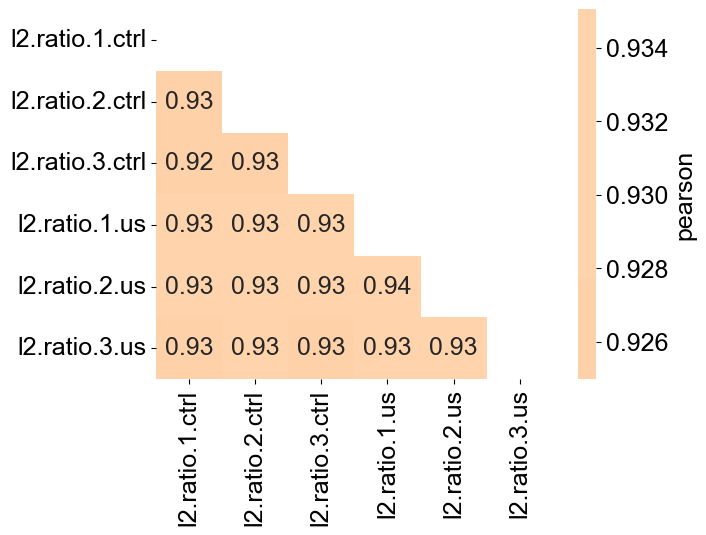

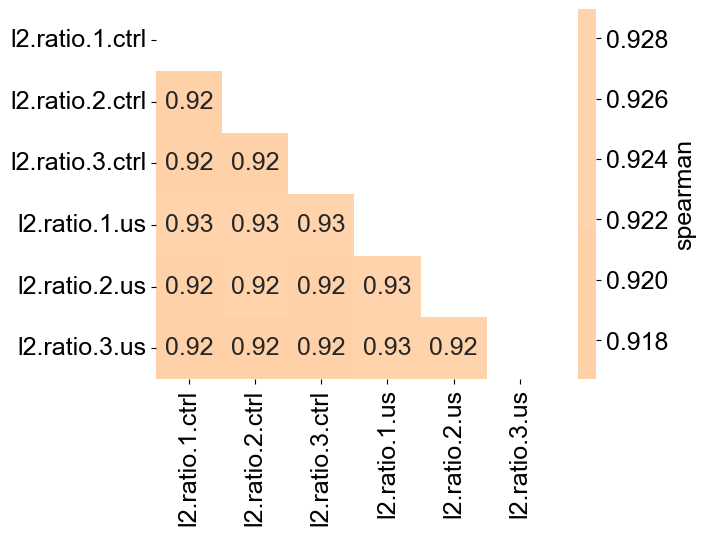

In [26]:
data = df
cols = ratios

plotCorrHeatMap(data,cols)

### distribution is very similar

[Text(0.5, 0, 'log2(RNA/DNA)')]

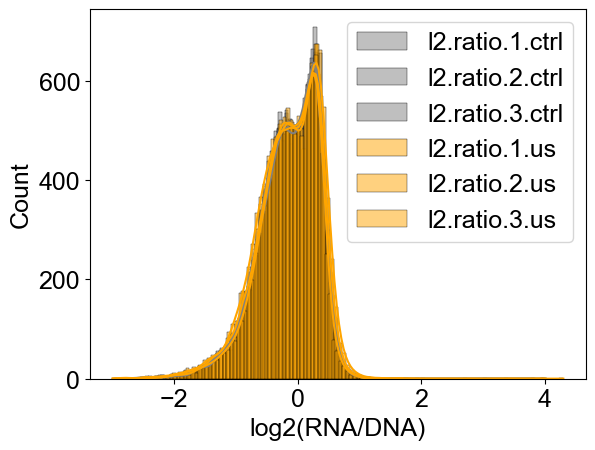

In [27]:
fig,ax=plt.subplots()

for col in ratios:
    color="orange"
    if "ctrl" in col:
        color="grey"
        
    sns.histplot(data[col].sample(frac=0.2), label=col, color=color, kde=True)
plt.legend()
ax.set(xlabel = 'log2(RNA/DNA)')

# Standard scaling per replicate

In [46]:
if os.path.exists(SCALED) is False:
    X = df[ratios]

    transformer = StandardScaler()

    t = pd.DataFrame(transformer.fit_transform(X[ratios]))

    t.columns = ratios # rename columns 

    ### mean, median of standardized values

    t = computeStats(t, ratios)

    # compute delta
    t = computeDelta(t)

    ### compute p value on standardized scale
    t = computePval(t, ratios)

    # add back names
    t = pd.merge(df['name'], t, left_index=True,right_index=True).drop_duplicates()

    t = t.loc[~t['name'].isna()] # remove any names that did not fit (more in df than t)
    
    # recall active
    t = callActive(t)

    # recall response
    t = callResponse(t)

    # add type information back into transformed dataframe
    t = pd.merge(t, df[["name", 
                    "type"]])
    
 
    t["pval"] = t["pval"].astype(float)
    t["-log10p"] = np.log10(t["pval"])*-1
    
    # write
    t.to_csv(SCALED, sep='\t', index=False)
    
    

else:
    t= pd.read_csv(SCALED, sep='\t')
t.head()

,name,l2.ratio.1.ctrl,l2.ratio.2.ctrl,l2.ratio.3.ctrl,l2.ratio.1.us,l2.ratio.2.us,l2.ratio.3.us,l2.ratio.med.ctrl,l2.ratio.mean.ctrl,l2.ratio.std.ctrl,...,l2.ratio.std.us,delta.med,delta.mean,pval,label.ctrl,label.us,response,direction,type,-log10p
0,"SYNTHETIC:_Added_GGGGCGGGG,CAGAGCTG,CTGATAAGGA...",-0.620021,-0.585774,-0.697189,-1.883558,-2.133393,-1.973695,-0.620021,-0.634328,0.057069,...,0.126521,-1.353675,-1.362554,0.000679,0,0,False,MORE_SILENT,Synthetic,3.167904
1,"SYNTHETIC:_Added_TATACATA,GCCCGGGGG,TATACATA,A...",0.259071,0.305156,0.315380,-0.106765,-0.055383,-0.078735,0.305156,0.293202,0.029997,...,0.025726,-0.383891,-0.373497,0.000095,0,0,False,US_DOWN,Synthetic,4.020486
2,SYNTHETIC:_The_motif_CAGAGCTG_was_added_in_Pos...,-0.517866,-0.483794,-0.559235,-0.816328,-0.936917,-1.002340,-0.517866,-0.520298,0.037780,...,0.094359,-0.419050,-0.398230,0.009865,0,0,False,MORE_SILENT,Synthetic,2.005902
3,SYNTHETIC:_The_motif_GAGATAAGGA_was_added_in_P...,-0.018014,0.119477,0.074187,-0.653532,-0.767229,-0.651184,0.074187,0.058550,0.070067,...,0.066331,-0.727719,-0.749198,0.000180,0,0,False,US_DOWN,Synthetic,3.744527
4,k562_atac_up_chr1:67191823-67192092,0.828031,0.814431,0.871116,0.983437,0.996373,1.079709,0.828031,0.837859,0.029593,...,0.052250,0.168342,0.181980,0.011772,0,1,True,MORE_ACTIVE,ATAC,1.929144


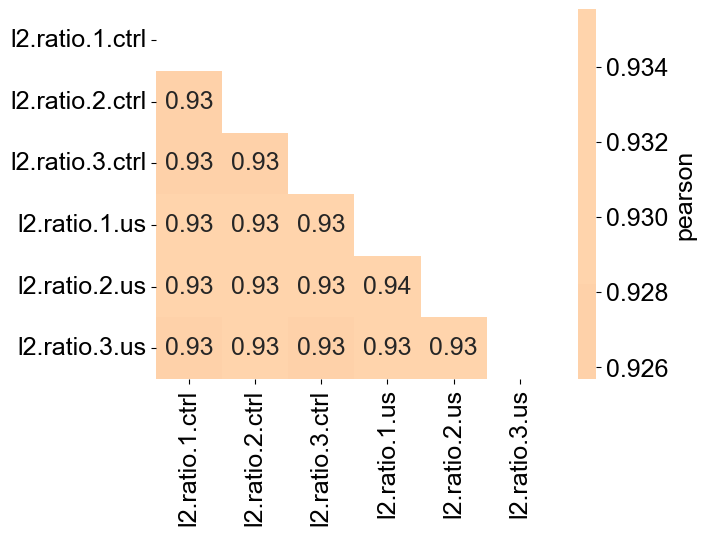

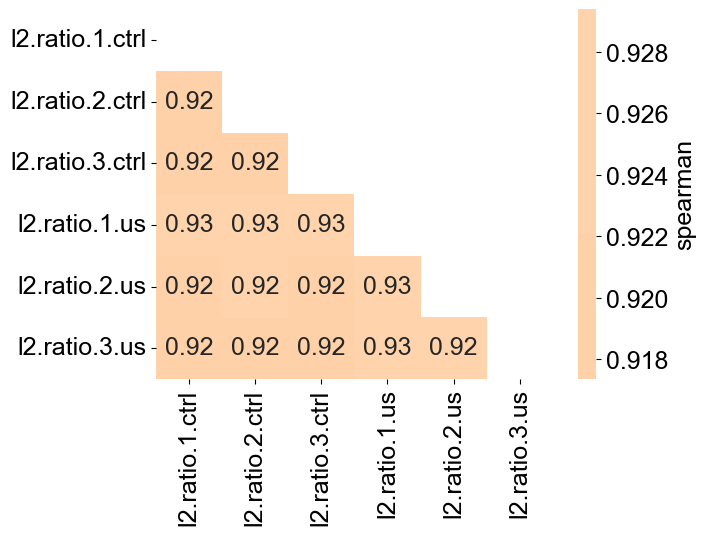

In [47]:
data = t
cols = ratios

plotCorrHeatMap(data,cols)

##### After transform, the correlations between the sets are still the same
##### but the values are scaled to account for variance between replicates

[Text(0.5, 0, 'log2(RNA/DNA)')]

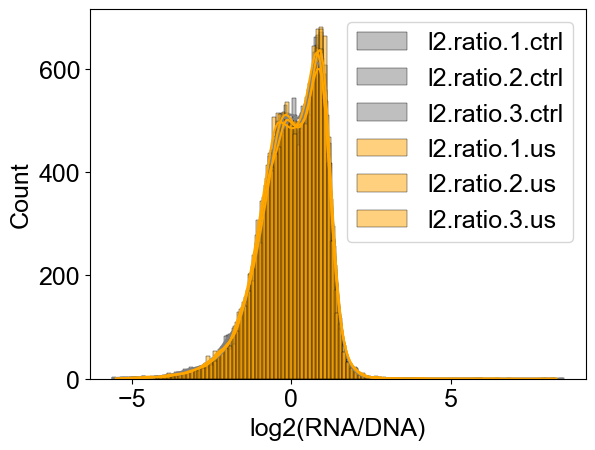

In [48]:
fig,ax=plt.subplots()
for col in ratios:
    color="orange"
    if "ctrl" in col:
        color="grey"
        
    sns.histplot(data[col].sample(frac=0.2), label=col, color=color, kde=True)
    
plt.legend(bbox_to_anchor=(1,1))
ax.set(xlabel = 'log2(RNA/DNA)')

## SD distribution

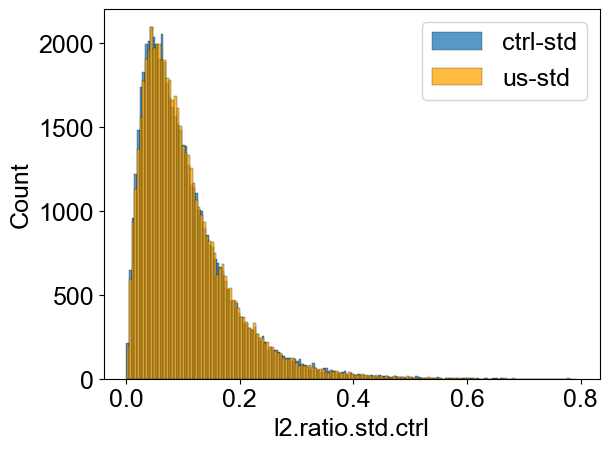

In [49]:
sns.histplot(x='l2.ratio.std.ctrl', data=df, label = 'ctrl-std')
sns.histplot(x='l2.ratio.std.us', data=df, label = 'us-std', color="orange")
plt.legend()

## standard deviations are somewhat correlated between ctrl and US
- desire to analyze elements with similar variance across two environments. 

,l2.ratio.std.ctrl,l2.ratio.std.us
l2.ratio.std.ctrl,1.000000,0.398448
l2.ratio.std.us,0.398448,1.000000


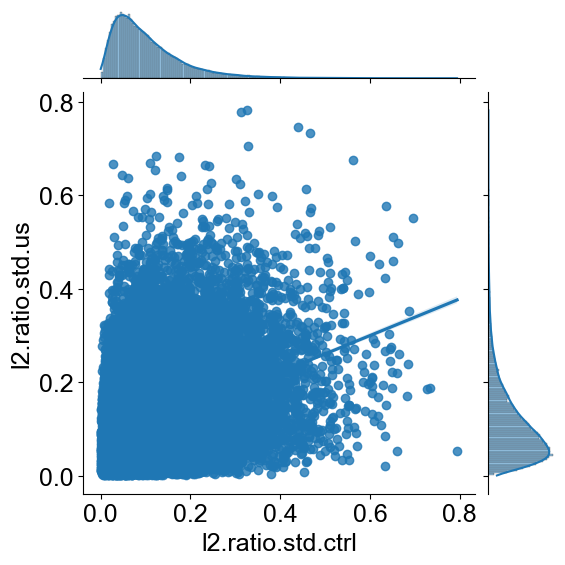

In [52]:
x='l2.ratio.std.ctrl'
y='l2.ratio.std.us'
sns.jointplot(x=x,y=y,data=df, kind="reg")
df[[x,y]].corr()

# US v. controls mean, median , sd

## not transformed

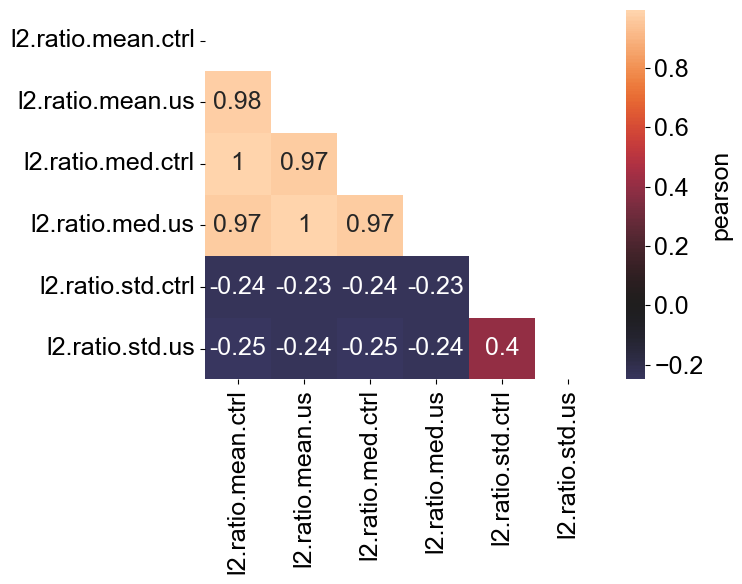

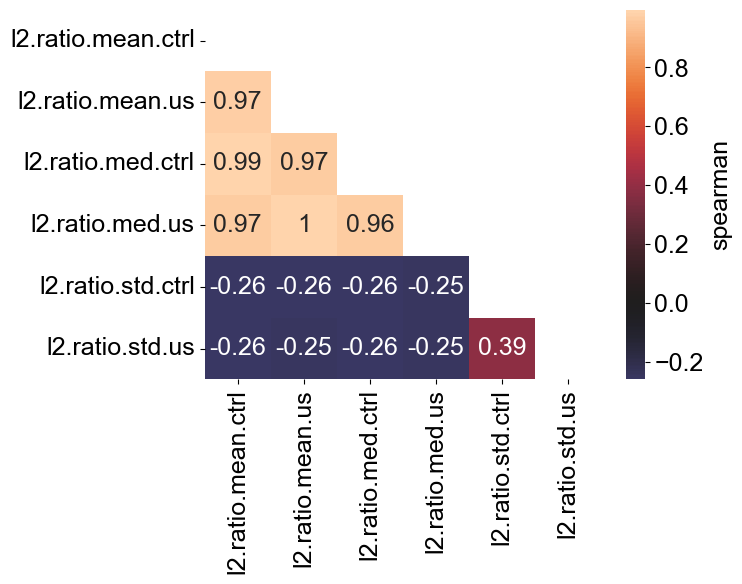

In [53]:
data = df
cols = ['l2.ratio.mean.ctrl', 'l2.ratio.mean.us',
        'l2.ratio.med.ctrl','l2.ratio.med.us', 
        'l2.ratio.std.ctrl','l2.ratio.std.us']

plotCorrHeatMap(data,cols)

### descriptive stats

In [54]:
data[cols].describe()

,l2.ratio.mean.ctrl,l2.ratio.mean.us,l2.ratio.med.ctrl,l2.ratio.med.us,l2.ratio.std.ctrl,l2.ratio.std.us
count,58333.000000,58333.000000,58333.000000,58333.000000,58333.000000,58333.000000
mean,-0.146814,-0.151555,-0.147043,-0.151846,0.104542,0.105496
std,0.470644,0.488555,0.472168,0.490006,0.079453,0.078234
min,-2.858338,-2.869390,-2.884952,-2.918264,0.000408,0.000779
25%,-0.426387,-0.447639,-0.426649,-0.448825,0.048010,0.049771
50%,-0.093083,-0.098858,-0.092891,-0.097897,0.084545,0.086176
75%,0.225519,0.237539,0.224935,0.236780,0.138896,0.139912
max,3.942584,4.220316,3.977579,4.217331,0.794111,0.781414


## transformed

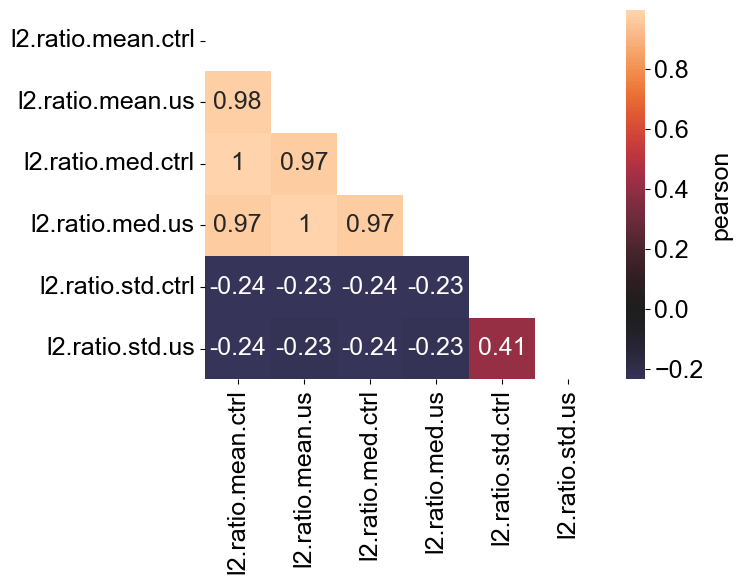

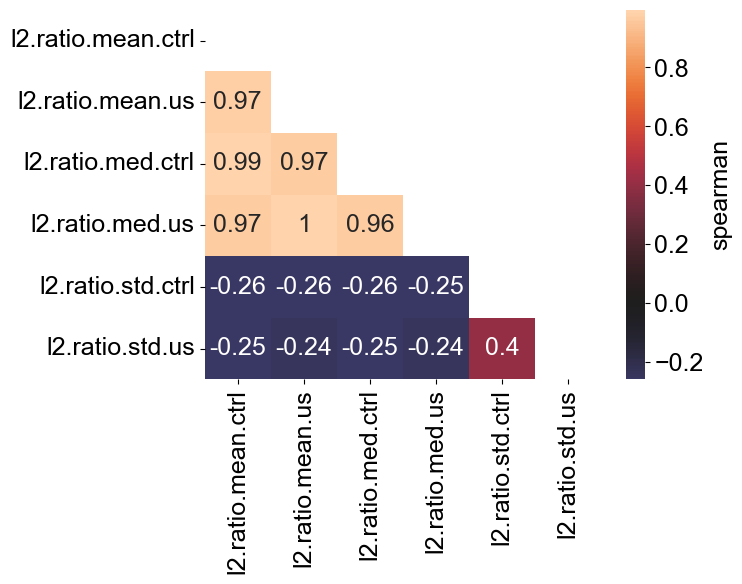

In [55]:
# transformed data
data = t

plotCorrHeatMap(data,cols)

### descriptive stats

In [56]:
data[cols].describe()

,l2.ratio.mean.ctrl,l2.ratio.mean.us,l2.ratio.med.ctrl,l2.ratio.med.us,l2.ratio.std.ctrl,l2.ratio.std.us
count,58180.000000,58180.000000,58180.000000,58180.000000,58180.000000,58180.000000
mean,0.001152,0.001144,0.000763,0.000313,0.215247,0.205064
std,0.974183,0.976680,0.977238,0.979979,0.163207,0.155528
min,-5.618572,-5.470273,-5.604151,-5.534922,0.000233,0.001443
25%,-0.577301,-0.591208,-0.578815,-0.593815,0.098579,0.093452
50%,0.112998,0.107660,0.113825,0.108551,0.174606,0.166477
75%,0.771670,0.779012,0.771102,0.777655,0.285991,0.273985
max,8.473488,8.755107,8.521717,8.738995,1.638308,1.699175


## pvalues of transformed v. not transformed

In [57]:
ps = pd.merge(t[["name", 'pval']], df[["name", 'pval']], 
              right_on = "name", left_on="name", suffixes = ("_transformed", "_not_transformed"))


ps.head()

,name,pval_transformed,pval_not_transformed
0,"SYNTHETIC:_Added_GGGGCGGGG,CAGAGCTG,CTGATAAGGA...",0.000679,0.000971
1,"SYNTHETIC:_Added_TATACATA,GCCCGGGGG,TATACATA,A...",0.000095,0.000253
2,SYNTHETIC:_The_motif_CAGAGCTG_was_added_in_Pos...,0.009865,0.000293
3,SYNTHETIC:_The_motif_GAGATAAGGA_was_added_in_P...,0.000180,0.000247
4,k562_atac_up_chr1:67191823-67192092,0.011772,0.000230


                      pval_not_transformed  pval_transformed
pval_not_transformed              1.000000          0.909094
pval_transformed                  0.909094          1.000000


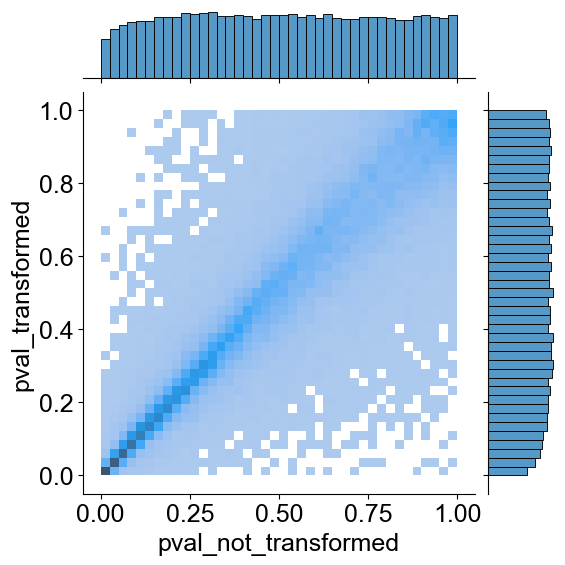

In [58]:
ps_cols =["pval_not_transformed", "pval_transformed"]
print(ps[ps_cols].corr())
sns.jointplot(x=ps_cols[0], y=ps_cols[1], data=ps, kind='hist')

# peaks

## load peak data, annotate direction of effect

In [59]:
# merge peaks with tiles
TRANSFORMED_SCORE = False
if LOCAL is True:
    PEAK_ANNOT = "/Users/sarahfong/Desktop/local_data/EMF/US/tilenames.x.enh.id.tsv"
else:
    PEAK_ANNOT = os.path.join(DATA_PATH, "genome_loci", "tilenames.x.enh.id.bed")
peaks = pd.read_csv(PEAK_ANNOT, sep='\t')
print(peaks.head())

if TRANSFORMED_SCORE is True:
    peaks = pd.merge(t, peaks)
    
    # files to write
    SIG_PEAK = os.path.join(DATA_PATH, f"{CL}.US_MPRA.sig_peak.dif.act.tiles.standardscale.tsv")
    SIG_PEAK_TILES = os.path.join(DATA_PATH, f"{CL}.US_MPRA.sig_peak.act.tiles.standardscale.tsv")
    out = os.path.join(DATA_PATH, f'{CL}.sig.peaks.standardscale.pdf')

else:    
    peaks = pd.merge(df, peaks)
    
    # files to write
    SIG_PEAK = os.path.join(DATA_PATH, f"{CL}.US_MPRA.sig_peak.dif.act.tiles.tsv")
    SIG_PEAK_TILES = os.path.join(DATA_PATH, f"{CL}.US_MPRA.sig_peak.act.tiles.tsv")
    out = os.path.join(DATA_PATH, f'{CL}.sig.peaks.pdf')

# 
peaks["dif"] = None
peaks.loc[(peaks['label.us']==True) &
         (peaks["label.ctrl"]==False) &
          (peaks["delta.med"]<0), "dif"] = "US.more.off"
peaks.loc[(peaks['label.us']==True) &
         (peaks["label.ctrl"]==False) &
          (peaks["delta.med"]>0), "dif"] = "US.on"

peaks.loc[(peaks['label.us']==False) &
         (peaks["label.ctrl"]==True)&
          (peaks["delta.med"]<0), "dif"] = "US.off"
peaks.loc[(peaks['label.us']==False) &
         (peaks["label.ctrl"]==True)&
          (peaks["delta.med"]>0), "dif"] = "US.less.off"

peaks.loc[(peaks['label.us']==True) &
         (peaks["label.ctrl"]==True), "dif"] = "no.effect.on"
peaks.loc[(peaks['label.us']==False) &
         (peaks["label.ctrl"]==False), "dif"] = "no.effect.off"

                                name              enh.id enh.name
0  hob_k27ac_down_chr1:826978-827247  chr1:826978-827704    enh.0
1  hob_k27ac_down_chr1:827110-827379  chr1:826978-827704    enh.0
2  hob_k27ac_down_chr1:827377-827646  chr1:826978-827704    enh.0
3  hob_k27ac_down_chr1:827435-827704  chr1:826978-827704    enh.0
4  hob_k27ac_down_chr1:827891-828160  chr1:827891-828160    enh.1


## order tiles in enhancer

In [74]:
ordered_enh = {}

# subset only enhancer, tile, tile names
# sort by name, then seq.id (which is ascending genomic order)
little_peaks = peaks[["enh.name", "seq.id", "name"]].drop_duplicates().copy().sort_values(by=["enh.name", "seq.id"])

# per enhancer, annotate tile order from seq.id
for enh_name in set(little_peaks["enh.name"]):

    # subset enh.name info and SORT by seq.id
    test = little_peaks.loc[little_peaks["enh.name"]==enh_name].copy().sort_values(by=["enh.name", "seq.id"]).reset_index(drop=True)
    test["tile.order"] = test.index  # index tile order
    ordered_enh[enh_name]= test

In [77]:
# create data
ORDERED_PEAKS = os.path.join(DATA_PATH, "tilenames.x.enh.id_ordered.tsv")
enh_order = pd.concat(ordered_enh.values())

# write 
enh_order.to_csv(ORDERED_PEAKS, sep='\t', index=False)

# add to # add enhancer order information to peaks.
peaks = pd.merge(peaks, enh_order)

In [78]:
enh_order.head(15)

,enh.name,seq.id,name,tile.order
0,enh.2758,seq.71112,hob_k27ac_up_chr13:74123071-74123340,0
1,enh.2758,seq.71113,hob_k27ac_up_chr13:74123203-74123472,1
2,enh.2758,seq.71114,hob_k27ac_up_chr13:74123338-74123607,2
3,enh.2758,seq.71115,hob_k27ac_up_chr13:74123470-74123739,3
4,enh.2758,seq.71116,hob_k27ac_up_chr13:74123603-74123872,4
0,enh.4854,seq.72277,hob_k27ac_up_chr18:33950995-33951264,0
1,enh.4854,seq.72278,hob_k27ac_up_chr18:33951127-33951396,1
2,enh.4854,seq.72279,hob_k27ac_up_chr18:33951262-33951531,2
3,enh.4854,seq.72280,hob_k27ac_up_chr18:33951394-33951663,3
4,enh.4854,seq.72281,hob_k27ac_up_chr18:33951527-33951796,4


### function - compute peakwise significance

In [79]:
def peakwise(enh_id, df):
    """ collect and perform related t-test on peak tiles in US/CTRL exposures
        - treat all tiles in peaks as repeated measures in two different conditions - US and CTRL
    """
    cols = ["name",
            'l2.ratio.med.ctrl',
            'label.ctrl',
            'l2.ratio.1.ctrl',
            'l2.ratio.2.ctrl',
            'l2.ratio.3.ctrl',
            'l2.ratio.med.us',
            'label.us',
            'l2.ratio.1.us',
            'l2.ratio.2.us',
            'l2.ratio.3.us',
            'delta.med',
            "dif", "enh.id", "enh.name"]

    # dget dataframe of enhancer only
    enh = df.loc[df["enh.id"] == enh_id, cols].copy()

    # treat all measurements as
    ctrls = list(pd.melt(enh,
                         value_vars=['l2.ratio.1.ctrl',
                                     'l2.ratio.2.ctrl',
                                     'l2.ratio.3.ctrl'])["value"])
    us = list(pd.melt(enh,
                      value_vars=['l2.ratio.1.us',
                                  'l2.ratio.2.us',
                                  'l2.ratio.3.us', ])["value"])
    # two related samples t-test, https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_rel.html
    s, p = stats.ttest_rel(ctrls, us)
    enh["peak_p"], enh["peak_stat"] = p, s

    return s, p, enh

### do computations per peak

In [80]:
sig_peaks = {}  # requires sig peak and categorical differential activity 
all_sig_peaks = {} # requires sig peak, DOES NOT REQUIRE categorical differential activity 

# parse through enhancer ids
for enh_id in peaks["enh.id"].unique():
    
    # perform repeated values t-test
    s, p, enh = peakwise(enh_id, peaks)
    
    if p<0.05:  # filter significant
        on_off= ["US.on", "US.more.on", "US.off", "US.more.off"]
        enh["dif"] =enh["dif"].astype(str)
        all_sig_peaks[enh_id] = enh
        
        # only pick differences 
        if len(set(enh["dif"]).intersection(set(on_off)))>0:
            sig_peaks[enh_id] = enh.loc[enh["dif"]!="None", 
                                        ["name", 
                                          "label.ctrl", 
                                          "label.us",
                                          'l2.ratio.med.ctrl',
                                          'l2.ratio.med.us',
                                          "delta.med", "dif", 
                                          "peak_p", "peak_stat", "enh.id", "enh.name"]]
    

sig = pd.concat(sig_peaks.values())  # every significant peak, regardless if its tiles have different activity or not
sig_all = pd.concat(all_sig_peaks.values()) # every significant peak with a tile that has different activity or not

sig.head()

,name,label.ctrl,label.us,l2.ratio.med.ctrl,l2.ratio.med.us,delta.med,dif,peak_p,peak_stat,enh.id,enh.name
10,hob_k27ac_up_chr8:109041277-109041546,0,1,0.294370,0.344973,0.050603,US.on,0.039543,-2.269859,chr8:109040745-109041546,enh.10473
8879,hob_k27ac_up_chr8:109040877-109041146,0,0,-1.279085,-1.216729,0.062355,no.effect.off,0.039543,-2.269859,chr8:109040745-109041546,enh.10473
12971,hob_k27ac_up_chr8:109040745-109041014,1,0,0.322673,0.305236,-0.017437,US.off,0.039543,-2.269859,chr8:109040745-109041546,enh.10473
20294,hob_k27ac_up_chr8:109041012-109041281,0,0,-0.055527,-0.061565,-0.006038,no.effect.off,0.039543,-2.269859,chr8:109040745-109041546,enh.10473
22297,hob_k27ac_up_chr8:109041144-109041413,0,0,-0.150783,-0.148649,0.002134,no.effect.off,0.039543,-2.269859,chr8:109040745-109041546,enh.10473


## plot peaks

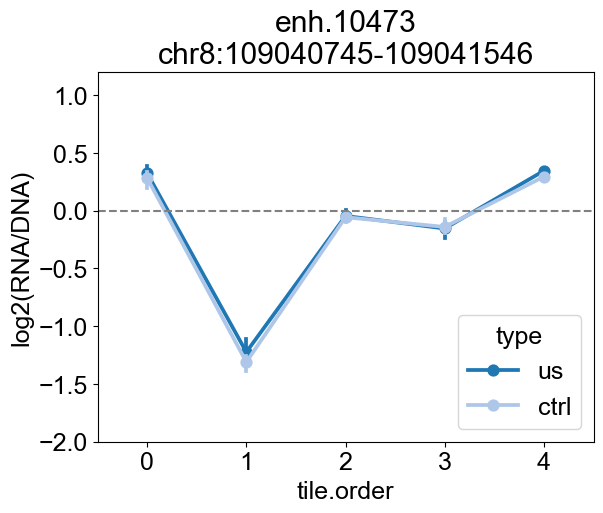

In [119]:
def plot_peak(peaks, enh_name):

    cols = ['l2.ratio.1.us',
            'l2.ratio.2.us',
            'l2.ratio.3.us', 'l2.ratio.1.ctrl',
            'l2.ratio.2.ctrl',
            'l2.ratio.3.ctrl', 'tile.order', "enh.id"]
    test = peaks.loc[peaks['enh.name'] == enh_name, cols]
    enh_id = test[cols[-1]].iloc[0]

    tm = pd.melt(test, id_vars=["enh.id", "tile.order"])
    tm['type'] = tm["variable"].apply(lambda x: x.split('.')[-1])
    x = "tile.order"
    y = 'value'
    hue = "type"
    data = tm
    fig, ax= plt.subplots()
    sns.pointplot(x=x, y=y, data=data, hue=hue, palette='tab20')
    ax.set(title=f"{enh_name}\n{enh_id}", 
          ylabel='log2(RNA/DNA)', 
          ylim=(-2, 1.2))
    ax.axhline(0, ls="--", color="grey")

# test
plot_peak(peaks, "enh.10473")

In [138]:
LUC_VAL = os.path.join(DATA_PATH, "validation_luc", "Candidate_ID_table_luc.txt")
validation_ids = pd.read_csv(LUC_VAL, sep='\t', usecols=["Sample name", 'insert'])
validation_ids

,Sample name,insert
0,BJ_D1,hob_atac_up_chr22:41305657-41305926
1,BJ_D2,hepg2_atac_down_chr10:109895366-109895635
2,BJ_D3,hob_atac_up_chr3:127734774-127735043
3,BJ_D4,SYNTHETIC:_Added_TGTAACAA_AGGTGTCA_AAGACCCCTC_...
4,BJ_D5,hob_k27ac_up_chr12:32115256-32115525
5,BJ_D6,SYNTHETIC:_Added_AGGGGAGGTATT_AGCAACCA_CCCCCGC...
6,BJ_D7,SYNTHETIC:_Added_GCCCGGGGG_GGCCATTAAC_TATGACTC...
7,BJ_D8,SYNTHETIC:_Added_GTGGTGTGTG_CGCCACGGCGGGGGTGGA...
8,BJ_D9,SYNTHETIC:_The_motif_GGGGCGGGG_was_added_in_Po...
9,BJ_U1,hob_k27ac_up_chr2:145036567-145036836


In [140]:
validation_ids.loc[validation_ids["insert"].isin(sig['name'])]

,Sample name,insert
0,BJ_D1,hob_atac_up_chr22:41305657-41305926
2,BJ_D3,hob_atac_up_chr3:127734774-127735043
12,BJ_U4,hob_atac_up_chr18:11954494-11954763
13,BJ_U5,k562_atac_up_chr7:1917897-1918166
14,BJ_U6,hob_k27ac_down_chr2:172439092-172439361
16,BJ_U8,bj_k27ac_up_chr4:53763341-53763610
17,BJ_U9,hob_atac_up_chr7:4689923-4690192


11    hob_k27ac_down_chr2:172439092-172439361
12    hob_k27ac_down_chr2:172438825-172439094
13    hob_k27ac_down_chr2:172438957-172439226
14    hob_k27ac_down_chr2:172439224-172439493
15    hob_k27ac_down_chr2:172439357-172439626
Name: name, dtype: object
173    k562_atac_up_chr7:1917897-1918166
174    k562_atac_up_chr7:1917832-1918101
Name: name, dtype: object
19    bj_k27ac_up_chr4:53763341-53763610
20    bj_k27ac_up_chr4:53763924-53764193
21    bj_k27ac_up_chr4:53763740-53764009
22    bj_k27ac_up_chr4:53763473-53763742
Name: name, dtype: object
44    hob_atac_up_chr3:127734774-127735043
45    hob_atac_up_chr3:127734840-127735109
Name: name, dtype: object
5    hob_atac_up_chr22:41305657-41305926
6    hob_atac_up_chr22:41305724-41305993
7    hob_atac_up_chr22:41305789-41306058
Name: name, dtype: object
16    hob_atac_up_chr18:11954494-11954763
17    hob_atac_up_chr18:11954428-11954697
18    hob_atac_up_chr18:11954560-11954829
Name: name, dtype: object
237    hob_atac_up_chr7:4689923-4

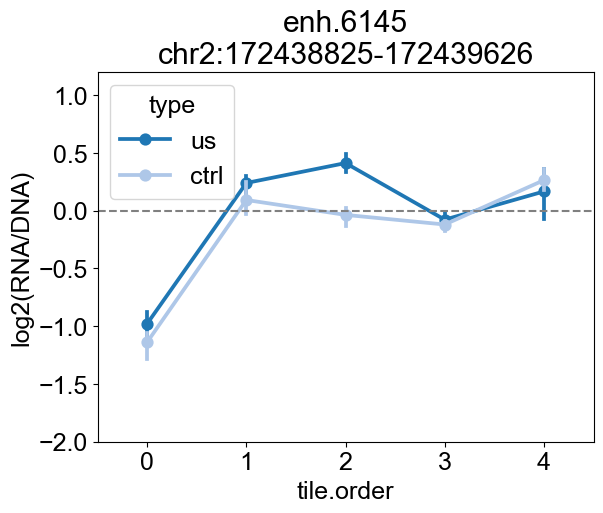

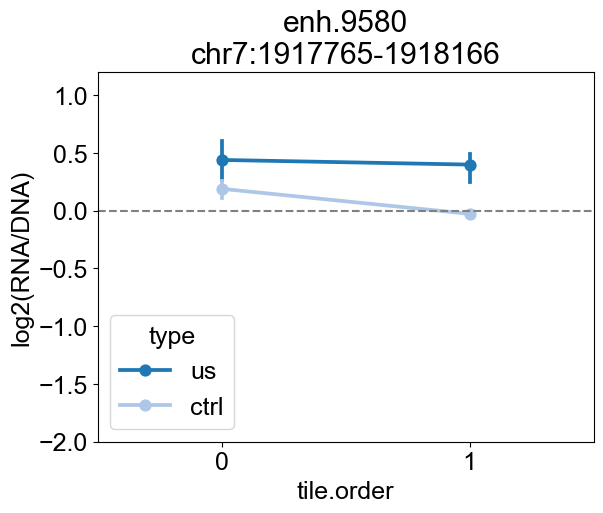

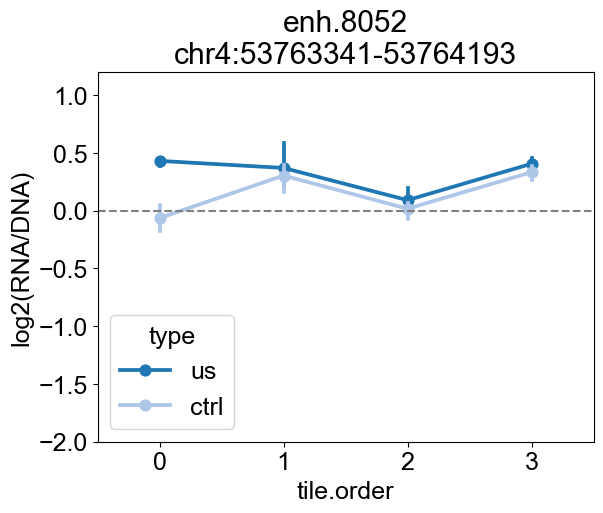

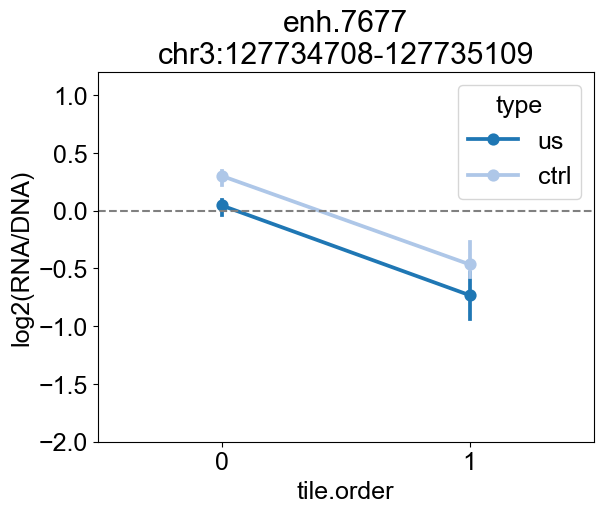

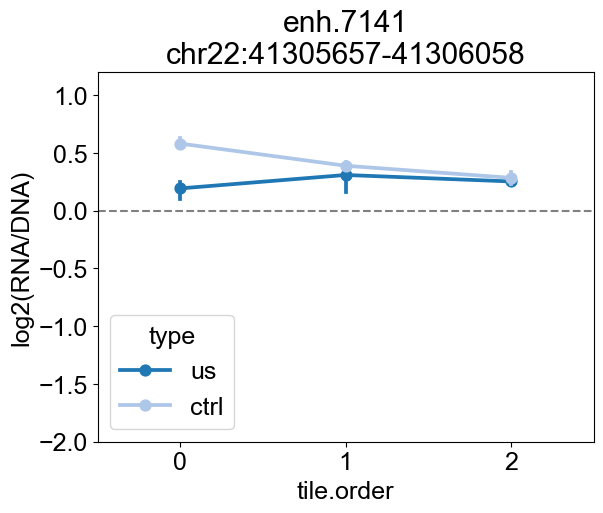

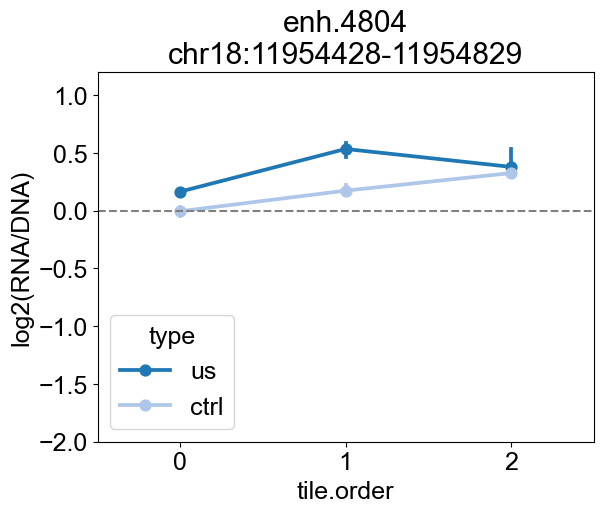

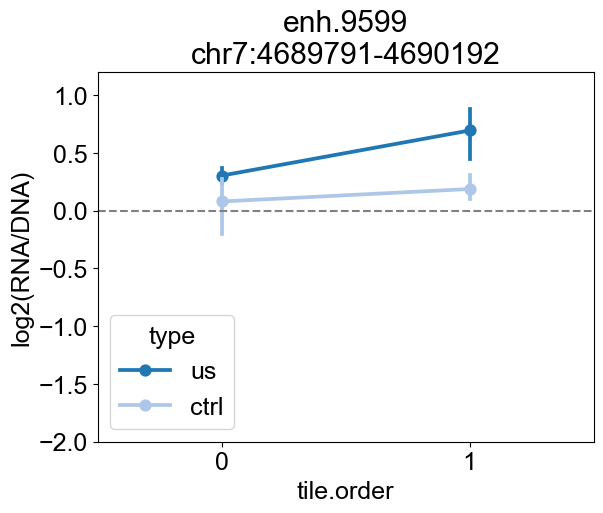

In [141]:
for n, enh_name in enumerate(set(sig.loc[sig['name'].isin(validation_ids["insert"]), "enh.name"])):
    print(sig.loc[sig["enh.name"]==enh_name, 'name'])
    plot_peak(peaks, enh_name)
    if n >10:
        break

In [139]:
enh_name

'enh.9599'

## find sig. peaks and differentially active tiles

In [112]:
sig_dif = sig.loc[sig["dif"].str.contains("US")].sort_values(by = "delta.med", ascending=False)
print(sig.shape, sig_dif.shape, sig_all.shape)

(487, 13) (176, 13) (1434, 17)


In [113]:
sig_dif

,name,label.ctrl,label.us,l2.ratio.med.ctrl,l2.ratio.med.us,delta.med,dif,peak_p,peak_stat,enh.id,enh.name,seq.id,tile.order
223,hob_k27ac_down_chr19:19202954-19203223,0,1,-0.088153,0.544140,0.632294,US.on,0.025304,-2.743711,chr19:19202822-19203623,enh.5243,seq.61938,1
237,hob_atac_up_chr7:4689923-4690192,0,1,0.153648,0.756076,0.602428,US.on,0.038923,-2.779543,chr7:4689791-4690192,enh.9599,seq.56315,1
146,bj_atac_up_chr11:29300564-29300833,0,1,-0.098416,0.465702,0.564119,US.on,0.035019,-2.403442,chr11:29300432-29300833,enh.1630,seq.41359,1
284,hob_atac_up_chr12:89544822-89545091,0,1,0.136110,0.667638,0.531528,US.on,0.037096,-2.820292,chr12:89544755-89545156,enh.2407,seq.51577,0
19,bj_k27ac_up_chr4:53763341-53763610,0,1,-0.069847,0.451002,0.520849,US.on,0.025194,-2.588755,chr4:53763341-53764193,enh.8052,seq.43392,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,hob_atac_up_chr22:41305657-41305926,1,0,0.572611,0.228093,-0.344518,US.off,0.028062,2.676869,chr22:41305657-41306058,enh.7141,seq.54465,0
353,hob_k27ac_down_chr2:200526302-200526571,1,0,0.406376,0.053582,-0.352793,US.off,0.037672,2.807201,chr2:200526035-200526836,enh.6253,seq.64939,0
207,hob_k27ac_up_chr21:27907633-27907902,1,0,0.495558,0.069219,-0.426339,US.off,0.046024,2.189176,chr21:27907234-27908035,enh.6875,seq.73540,3
300,hob_k27ac_down_chr1:20589741-20590010,1,0,0.478893,0.014015,-0.464877,US.off,0.021544,2.676463,chr1:20589209-20590067,enh.144,seq.63231,3


## write peaks

In [36]:
sig_dif.to_csv(SIG_PEAK, sep='\t')  # only differentially active tiles 
sig_all.to_csv(SIG_PEAK_TILES, sep='\t') # all tiles

## plot tile effect size and peak p-value 

/Users/sarahfong/miniconda3/envs/base_venv/lib/python3.6/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_incehs" which is no longer supported as of 3.3 and will become an error two minor releases later
  if __name__ == '__main__':


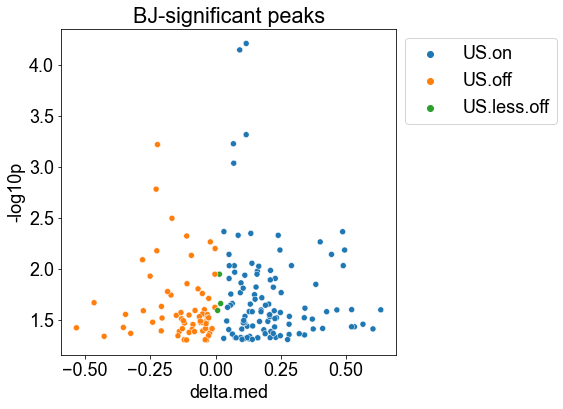

In [37]:
sig["-log10p"] = -1*np.log10(sig["peak_p"])

fig,ax = plt.subplots(figsize=(6,6))
sns.scatterplot(x='delta.med', y="-log10p", data=sig.loc[sig["dif"].str.contains("US")], hue="dif")
ax.set(title=f"{CL}-significant peaks")
plt.legend(bbox_to_anchor=(1,1))


plt.savefig(out, bbox_incehs="tight")

## transformed v. non-transformed peak significance  

In [38]:
TRANS = os.path.join(DATA_PATH, f"{CL}.US_MPRA.sig_peak.dif.act.tiles.standardscale.tsv")
NOTRANS = os.path.join(DATA_PATH, f"{CL}.US_MPRA.sig_peak.dif.act.tiles.tsv")

t_names = pd.read_csv(TRANS, sep='\t', usecols =["name"])
nt_names = pd.read_csv(NOTRANS, sep='\t', usecols =["name"])

trans_names = set(t_names["name"])
notrans_names = set(nt_names["name"])

len(trans_names.intersection(notrans_names)), len(trans_names), len(notrans_names)

(129, 197, 176)